# Exercises: physics-informed neural network

Exercise on the implementation of physics-informed neural network. 

Author: Stefano Pagani <stefano.pagani@polimi.it>.

Date: 2024

Course: Mathematical and numerical foundations of scientific machine learning.

Example adapted from this [notebook](https://colab.research.google.com/drive/1qBrbgevkSBqqYc8bOPiaoJG1MBrBrluN?usp=share_link). 


Let us consider the problem

\begin{aligned}
  & -\nu \Delta u = -2(x^2+y^2)  \,, \quad (x,y) \in [-1,1] \times [-1,1]\,,\\
  & u(x,-1) = u(x,1) = -x^2 \,, \quad -1 < x < 1\,, \\
  & u(-1,y) = u(1,y) = -y^2 \,, \quad -1 < y < 1\,, \\
\end{aligned}

where $\nu=1$. We consider the PINN framework for solving this PDE.

In [35]:
# import required libraries

import tensorflow as tf
import numpy as np
import scipy.io
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#!pip -q install pyDOE
from pyDOE import lhs  # for latin hypercube sampling


# Solution

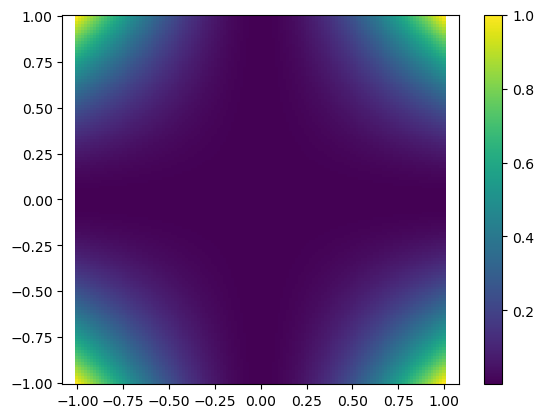

In [36]:
# Plot exact solution of PDE
nu = 1.0 # diffusion parameter (truth)

# Define grid for sampling the exact solution
N_h = 128
ux = np.linspace(-1.0,1.0,N_h)
uy = np.linspace (-1.0,1.0,N_h)

# Sampling loop --> Collocation points (NOTE: this represents the truth of the problem)
u_true = np.zeros([N_h,N_h])
for i in range(N_h):
    u_true[:,i] = (ux[i]**2)*(uy**2)

X_plot,Y_plot = np.meshgrid(ux,uy)
plt.pcolor(X_plot, Y_plot, u_true)
plt.axis('equal')
plt.colorbar()



In [37]:
# Flatten grid and solution (to have a 1D array representation of the data)
X,Y = np.meshgrid(ux,uy)
X_flat = tf.convert_to_tensor(np.hstack((X.flatten()[:,None],Y.flatten()[:,None])),dtype=tf.float64)
u_flat = u_true.T.flatten()

In [38]:
#np.shape(u_true) 

np.shape(u_flat)

(16384,)

In [39]:
# PINN loss function definition
def loss(xcl,ycl,xlb,ylb,ulb,xub,yub,uub,xleft,yleft,uleft,xright,yright,uright):
    #u0_pred  = PINN(tf.concat([x0,t0],1))
    # TODO: what concat does? vectors xln, ylb concatenation I guess, on the first axis
    ulb_pred = PINN(tf.concat([xlb,ylb],1))
    uub_pred = PINN(tf.concat([xub,yub],1))
    uleft_pred = PINN(tf.concat([xleft,yleft],1))
    uright_pred = PINN(tf.concat([xright,yright],1))
    r_pred   = r_PINN(xcl,ycl)

    # loss components
    #mse_0  = tf.reduce_mean(tf.pow(u0-u0_pred,2))
    # TODO: check what reduce_mean does? --> Compute mean over axis specified by the second function input
    # DEFAULT: axis=None --> mean over ALL dims squeezing the N rank tensor to a scalar tensor
    mse_lb = tf.reduce_mean(tf.pow(ulb_pred-ulb,2)) # MSE error at Upper bound
    mse_ub = tf.reduce_mean(tf.pow(uub_pred-uub,2)) # MSE error at Lower bound
    mse_left = tf.reduce_mean(tf.pow(uleft_pred-uleft,2)) # MSE error at left bound
    mse_right = tf.reduce_mean(tf.pow(uright_pred-uright,2)) # MSE error at right bound
    mse_r  = tf.reduce_mean(tf.pow(r_pred,2)) # MSE of residuals of output wrt PDE solution

    return mse_r+mse_lb+mse_ub+mse_left+mse_right #mse_0+mse_r+mse_lb+mse_ub

# Neural Network Weight Gradients: define function to make Tensorflow computing the gradient of the loss function
@tf.function(jit_compile=False) # jit_compile is not trivial to use --> it won't work here 
def grad(model,xcl,ycl,xlb,ylb,ulb,xub,yub,uub,xleft,yleft,uleft,xright,yright,uright):
    with tf.GradientTape(persistent=True) as tape:
        # Evaluate the loss function in all the available points (boundary)
        loss_value = loss(xcl,ycl,xlb,ylb,ulb,xub,yub,uub,xleft,yleft,uleft,xright,yright,uright)
        grads = tape.gradient(loss_value,model.trainable_variables) 
        # Tensorflow can output gradients of the loss funciton automatically with respect to the "trainable_variables"
    return loss_value, grads

In [40]:
# Collocation points for PDE "enforcing"
np.random.seed(seed=1) 
# TODO: Check if seed setting is correctly working: in principle the output of the sampling should be the same at each trial

Ncl = 2000
X = lhs(2,Ncl) # Latin Hypercube sampling of dimension N=2 and Ncl samples
# TODO: check documentation of expand_dims function
# cast simply casts from input dtype to specified dtype
# expand_dims expands the array adding a dimension (fixed to length 1) in axis specified by second input (no default)
xcl = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,0], dtype=tf.float64),axis=-1) # Expand collocation points to tensors
ycl = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,1], dtype=tf.float64),axis=-1)
X_coll = tf.concat([xcl,ycl],1)


# Dirichlet boundary condition points --> Simulate samples for the training (on the boundary)
Nb = 500 # Number of samples on the boundary
X = lhs(1,Nb)
ylb = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,0],dtype=tf.float64),axis=-1)
xlb = -1.0*tf.ones(tf.shape(ylb),dtype=tf.float64)
ulb = (xlb**2)*(ylb**2)
X_lb = tf.concat([xlb,ylb],1)

X = lhs(1,Nb)
yub = tf.expand_dims(tf.cast(-1.0+(2.0)*X[:,0],dtype=tf.float64),axis=-1)
xub = 1.0*tf.ones(tf.shape(yub),dtype=tf.float64)
uub = (xub**2)*(yub**2)
X_ub = tf.concat([xub,yub],1)

Y = lhs(1,Nb)
xleft = tf.expand_dims(tf.cast(-1.0+(2.0)*Y[:,0],dtype=tf.float64),axis=-1)
yleft = -1.0*tf.ones(tf.shape(xleft),dtype=tf.float64)
uleft = (xleft**2)*(yleft**2)
X_left = tf.concat([xleft,yleft],1)

Y = lhs(1,Nb)
xright = tf.expand_dims(tf.cast(-1.0+(2.0)*Y[:,0],dtype=tf.float64),axis=-1)
yright = 1.0*tf.ones(tf.shape(xright),dtype=tf.float64)
uright = (xright**2)*(yright**2)
X_right = tf.concat([xright,yright],1)



In [41]:
# NOTE: differentiability of the activation function is key for PINNs training: this is why tanh is one common way to go

# Define the network architecture object
# Check keras.Sequential class (what are the options?)
PINN = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='tanh', input_shape=(2,),kernel_initializer="glorot_normal",dtype=tf.float64),
    tf.keras.layers.Dense(32, activation='tanh',kernel_initializer="glorot_normal",dtype=tf.float64),
    tf.keras.layers.Dense(1,activation=None,kernel_initializer="glorot_normal",dtype=tf.float64)
])



In [42]:

# Residual computation based on AD
@tf.function
def r_PINN(x,y):
    u    = PINN(tf.concat([x,y], 1))
    u_x  = tf.gradients(u,x)[0]
    u_xx = tf.gradients(u_x, x)[0] # Second partial derivative of u wrt x
    u_y  = tf.gradients(u,y)[0]
    u_yy = tf.gradients(u_y, y)[0]
    return - u_xx - u_yy + 2.0*( tf.pow(x,2) + tf.pow(y,2) ) # PDE in the form of F(x)=0 (TBC)
# Check type of equation --> it seems like Laplace + source: Poisson?


# Adam optimizer
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.003,beta_1=0.99)

for iter in range(5000):

  # compute gradients using AD
  loss_value,grads = grad(PINN,xcl,ycl,xlb,ylb,ulb,xub,yub,uub,xleft,yleft,uleft,xright,yright,uright)

  # update neural network weights
  tf_optimizer.apply_gradients(zip(grads,PINN.trainable_variables))

  # display intermediate results
  if ((iter+1) % 200 == 0):
    print('iter =  '+str(iter+1))
    print('loss = {:.4f}'.format(loss_value))
    PINN_flat = PINN(X_flat)
    err = np.linalg.norm(u_flat-PINN_flat[:,-1],2)/np.linalg.norm(u_flat,2)
    print('L2 error: %.4e' % (err))
    

iter =  200
loss = 1.5016
L2 error: 5.9932e-01
iter =  400
loss = 0.9566
L2 error: 4.7148e-01
iter =  600
loss = 0.5781
L2 error: 5.2032e-01
iter =  800
loss = 0.1436
L2 error: 4.3460e-01
iter =  1000
loss = 0.0834
L2 error: 3.5553e-01
iter =  1200
loss = 0.0507
L2 error: 2.6781e-01
iter =  1400
loss = 0.0224
L2 error: 1.6457e-01
iter =  1600
loss = 0.0102
L2 error: 5.3605e-02
iter =  1800
loss = 0.0066
L2 error: 5.8453e-02
iter =  2000
loss = 0.0045
L2 error: 4.6702e-02
iter =  2200
loss = 0.0032
L2 error: 4.1589e-02
iter =  2400
loss = 0.0024
L2 error: 3.7679e-02
iter =  2600
loss = 0.0018
L2 error: 3.3852e-02
iter =  2800
loss = 0.0014
L2 error: 2.9334e-02
iter =  3000
loss = 0.0010
L2 error: 2.4547e-02
iter =  3200
loss = 0.0007
L2 error: 1.9638e-02
iter =  3400
loss = 0.0005
L2 error: 1.5025e-02
iter =  3600
loss = 0.0003
L2 error: 1.1401e-02
iter =  3800
loss = 0.0002
L2 error: 9.2279e-03
iter =  4000
loss = 0.0002
L2 error: 8.1552e-03
iter =  4200
loss = 0.0002
L2 error: 7.5701e

Text(0.5, 1.0, 'L2 error = 0.0064')

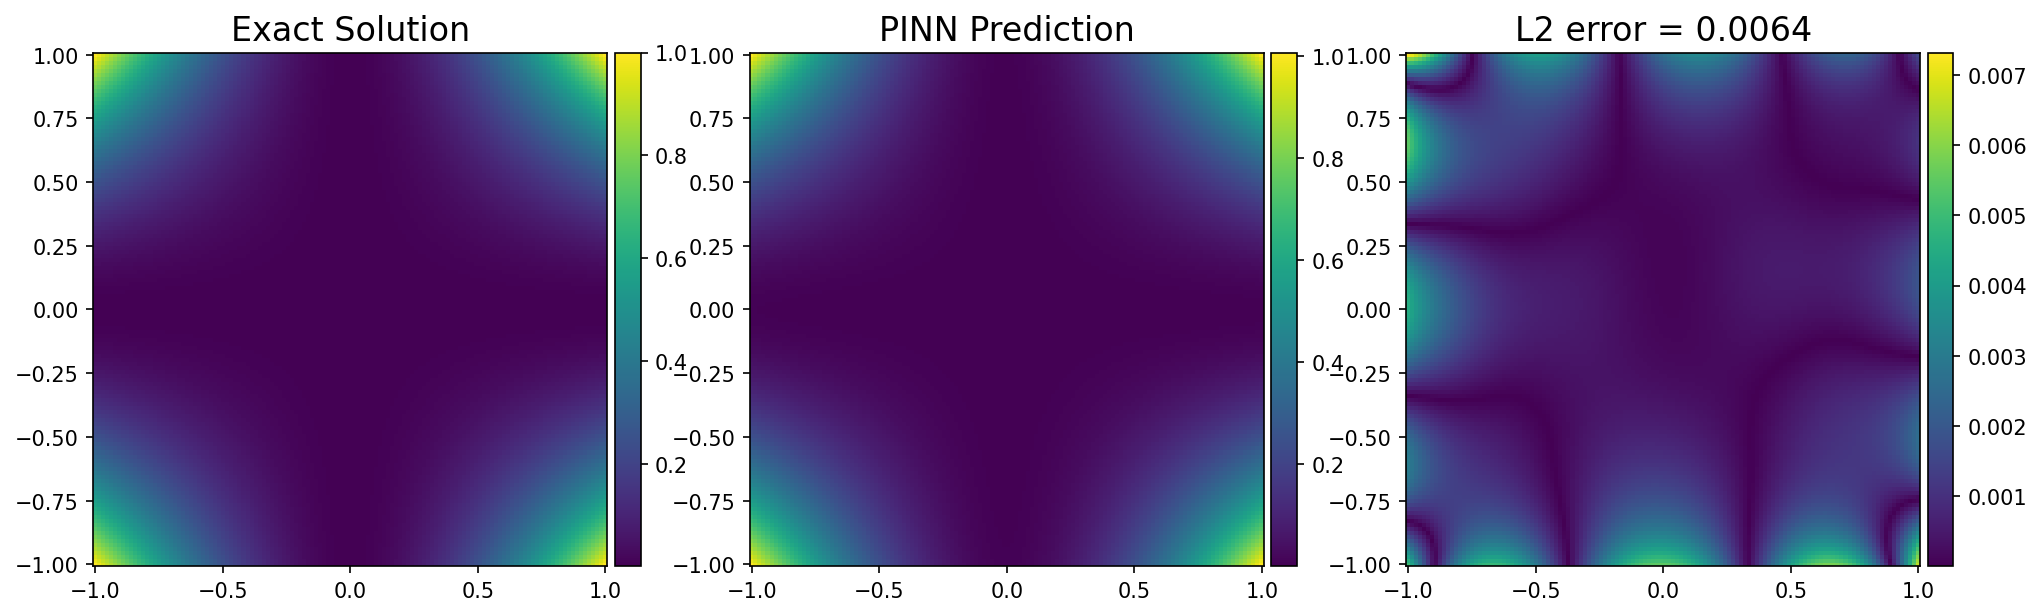

In [43]:
#Display results

fig = plt.figure(figsize=(16,9),dpi=150)
#fig = plt.figure()
#fig.subplots_adjust(wspace=0.3)
plt.style.use('default')
ax = fig.add_subplot(1,3,1)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, u_true)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
#ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])
ax.set_title('Exact Solution',fontsize=16)

ax = fig.add_subplot(1,3,2)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, np.reshape(PINN_flat,(N_h,N_h)))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_title('PINN Prediction'.format(err),fontsize=16)

ax = fig.add_subplot(1,3,3)
ax.set_aspect(1)
im = plt.pcolor(X_plot, Y_plot, np.abs( np.reshape(PINN_flat,(N_h,N_h)) -u_true ) )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_title('L2 error = {:.4f}'.format(err),fontsize=16)